In [108]:
### Function for seismic facies prediction using Convolutional Neural Nets (CNN)
### By: Charles Rutherford Ildstad
### Date: 22.10.2017
### For: ConocoPhillips, Tananger,

%matplotlib inline

# Make initial package imports
import segyio
import random
import keras
import numpy as np
import matplotlib.pyplot as plt
import math
import time
#
import os

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv3D
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler
from matplotlib import gridspec

from keras.layers.normalization import BatchNormalization

from shutil import copyfile

# Set random seed for reproducability
np.random.seed(7)
# Confirm backend if in doubt
#keras.backend.backend()

In [109]:
# parameters for training or predicting
filenames=['F3_entire.segy']    # name of the segy-cube(s) with data , separate by comma 'volume' for additional volumes
inp_res = np.float32    # formatting of the input seismic (e.g. np.int8 for 8-bit data, np.float32 for 32-bit data, etc)
cube_incr = 32    # number of increments in each direction to create a training cube

# SEGY iline/xline/t dimensions:
ils=100; ile=750; ili=1
xls=300; xle=1250; xli=1
ts=4; te=1848; ti=4
    
# Define the dictionary holding all the training parameters
train_dict = {
    'files' : ['multi_else_ilxl.pts','multi_grizzly_ilxl.pts','multi_high_amp_continuous_ilxl.pts',
               'multi_high_amplitude_ilxl.pts','multi_low_amp_dips_ilxl.pts',
               'multi_low_amplitude_ilxl.pts','multi_low_coherency_ilxl.pts',
               'multi_salt_ilxl.pts','multi_steep_dips_ilxl.pts'],    # list of names of class-adresses
    'num_tot_iterations': 25,    # number of times we draw a new training ensemble/mini-batch
    'epochs' : 10,    # number of epochs we run on each training ensemble/mini-batch
    'num_train_ex' : 20000,    # number of training examples in each training ensemble/mini-batch
    'batch_size' : 32,    # number of training examples fed to the optimizer as a batch
    'opt_patience' : 10,    # number of epochs with the same accuracy before force breaking the training ensemble/mini-batch
    'data_augmentation' : False,    # whether or not we are using data augmentation
    'save_model' : True,    # whether or not we are saving the trained model
    'save_location' : 'F3_fullstack_multi_25i_10e_20000'    # file name for the saved trained model
}

# add directory prefix

# 1. dir for classification data
classification_data_dir = 'F3_classification_data'
# actual classification data file names
files_with_dir=[]
for file in train_dict['files']:
    files_with_dir.append(os.path.join(classification_data_dir, file))
train_dict['files'] = files_with_dir

# 2. dir for seismic data
segy_data_dir = 'F3_seismic_data'
# actual file names
filenames_with_dir=[]
for file in filenames:
    filenames_with_dir.append(os.path.join(segy_data_dir, file))
filenames = filenames_with_dir

# 3. dir for output 
out_dir = 'F3_output'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
# 
train_dict['save_location'] = os.path.join(out_dir, train_dict['save_location'])

# for prediction
# Define the dictionary holding all the prediction parameters
pred_dict = {
    'keras_model' :  keras.models.load_model(train_dict['save_location']+'.h5'), # input model to be used for prediction, to load a model use: keras.models.load_model('write_location')
    #'section_edge' : np.asarray([132, 718, 400, 400, 132, 1720]), # inline and xline section to be predicted (all depths), must contain xline
    'section_edge' : np.asarray([339, 339, xls, xle, ts, te]),   # use inline 339
    'show_feature' : False,    # Show the distinct features before they are combined to a prediction
    'xline' : 400, #123900,    # xline used for classification (index)(should be within section range)
    'num_class' : len(train_dict['files']),    # number of classes to output
    'cord_syst' : 'segy',    # Coordinate system used, default is 0,0. Set to 'segy' to give inputs in (inline,xline)
    'save_pred' : True,    # Save the prediction as a segy-cube
    'save_location' : 'F3_fullstack_multi_25i_10e_20000_facies_classes',     # file name for the saved prediction
    'pred_batch' : 25,     # number of traces used to make batches of mini-cubes that are stored in memory at once
    #'pred_batch' : train_dict['num_train_ex']//(pred_dict['section_edge'][5]-pred_dict['section_edge'][4])    #Suggested value
    'pred_prob' : False     # Give the probabilities of the first class(True), or simply show where each class is classified(False)
}

pred_dict['save_location']  = os.path.join(out_dir, pred_dict['save_location'])


In [110]:
### ---- Functions for Input data(SEG-Y) formatting and reading ----
# Make a function that decompresses a segy-cube and creates a numpy array, and
# a dictionary with the specifications, like in-line range and time step length, etc.
def segy_decomp(segy_file, plot_data = False, read_direc='xline', inp_res = np.float64):
    # segy_file: filename of the segy-cube to be imported
    # plot_data: boolean that determines if a random xline should be plotted to test the reading
    # read_direc: which way the SEGY-cube should be read; 'xline', or 'inline'
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)

    # Make an empty object to hold the output data
    print('Starting SEG-Y decompressor')
    output = segyio.spec()

    # open the segyfile and start decomposing it
    with segyio.open(segy_file, "r" ) as segyfile:
        # Memory map file for faster reading (especially if file is big...)
        segyfile.mmap()

        # Store some initial object attributes
        output.inl_start = segyfile.ilines[0]
        output.inl_end = segyfile.ilines[-1]
        output.inl_step = segyfile.ilines[1] - segyfile.ilines[0]

        output.xl_start = segyfile.xlines[0]
        output.xl_end = segyfile.xlines[-1]
        output.xl_step = segyfile.xlines[1] - segyfile.xlines[0]

        output.t_start = int(segyfile.samples[0])
        output.t_end = int(segyfile.samples[-1])
        output.t_step = int(segyfile.samples[1] - segyfile.samples[0])

        # for qc
        print(" SEGY inline/xline/t geometry:")
        print(" ils={}, ile={}, ili={}, ilen={}\n".format(output.inl_start, output.inl_end, 
                                                          output.inl_step,
                                                          segyfile.xline.len))  # WARNING: WEIRD!!!
        print(" xls={}, xle={}, xli={}, xlen={}\n".format(output.xl_start, output.xl_end, 
                                                          output.xl_step,
                                                          segyfile.iline.len))  # WARNING: WEIRD!!!
        print(" ts={}, te={}, ti={}\n".format(output.t_start, output.t_end, output.t_step))

        # Pre-allocate a numpy array that holds the SEGY-cube
        output.data = np.empty((segyfile.xline.len, segyfile.iline.len, \
                               (output.t_end - output.t_start)//output.t_step+1), 
                               dtype = np.float32)

        # Read the entire cube line by line in the desired direction
        if read_direc == 'inline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for il_index in range(segyfile.xline.len):     # WARNING: WEIRD!!!
                output.data[il_index,:,:] = segyfile.iline[segyfile.ilines[il_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'xline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for xl_index in range(segyfile.iline.len):    # WARNING: WEIRD!!!
                output.data[:,xl_index,:] = segyfile.xline[segyfile.xlines[xl_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'full':
            ## NOTE: 'full' for some reason invokes float32 data
            # Potentially time this to find the "fast" direction
            #start = time.time()
            output.data = segyio.tools.cube(segy_file)
            #end = time.time()
            #print(end - start)
        else:
            print('Define reading direction(read_direc) using either ''inline'', ''xline'', or ''full''')


        # Convert the numpy array to span between -127 and 127 and convert to the desired format
        factor = 127/np.amax(np.absolute(output.data))
        if inp_res == np.float32:
            output.data = (output.data*factor)
        else:
            output.data = (output.data*factor).astype(dtype = inp_res)

        # If sepcified, plot a given x-line to test the read data
        if plot_data:
            # xline = 100
            xline = np.random.randint(output.data.shape[1])

            # Take a given xline
            data = output.data[:,xline,:]
            
            # Plot the read x-line
            plt.imshow(data.T,interpolation="nearest", cmap="gray")
            plt.title(' xline={}'.format(xline))
            plt.colorbar()
            plt.show()


    # Return the output object
    print('Finished using the SEG-Y decompressor')
    return output

# qc segy_decomp
segy_obj = segy_decomp(segy_file = filenames[0],
                       plot_data = False,
                       read_direc = 'full',
                       inp_res = np.float32)

# If sepcified, plot a given x-line to test the read data
# Take a given xline
iline = 239
data = segy_obj.data[iline, :,:]
# Plot the read x-line
plt.imshow(data.T,interpolation="nearest", cmap="rainbow", vmin=-15, vmax=15)
plt.colorbar()
plt.show()

In [111]:
# Make a function that adds another layer to a segy-cube
def segy_adder(segy_file, inp_cube, read_direc='xline', inp_res = np.float64):
    # segy_file: filename of the segy-cube to be imported
    # inp_cube: the existing cube that we should add a layer to
    # cube_num: which chronological number of cube is this
    # read_direc: which way the SEGY-cube should be read; 'xline', or 'inline'
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)

    # Make a variable to hold the shape of the input cube and preallocate a data holder
    print('Starting SEG-Y adder')
    cube_shape = inp_cube.shape
    dataholder = np.empty(cube_shape[0:-1])

    # open the segyfile and start decomposing it
    with segyio.open(segy_file, "r" ) as segyfile:
        # Memory map file for faster reading (especially if file is big...)
        segyfile.mmap()

        # Read the entire cube line by line in the desired direction
        if read_direc == 'inline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for il_index in range(segyfile.xline.len):
                dataholder[il_index,:,:] = segyfile.iline[segyfile.ilines[il_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'xline':
            # Potentially time this to find the "fast" direction
            #start = time.time()
            for xl_index in range(segyfile.iline.len):
                dataholder[:,xl_index,:] = segyfile.xline[segyfile.xlines[xl_index]]
            #end = time.time()
            #print(end - start)

        elif read_direc == 'full':
            ## NOTE: 'full' for some reason invokes float32 data
            # Potentially time this to find the "fast" direction
            #start = time.time()
            dataholder[:,:,:] = segyio.tools.cube(segy_file)
            #end = time.time()
            #print(end - start)
        else:
            print('Define reading direction(read_direc) using either ''inline'', ''xline'', or ''full''')


        # Convert the numpy array to span between -127 and 127 and convert to the desired format
        factor = 127/np.amax(np.absolute(dataholder))
        if inp_res == np.float32:
            dataholder = (dataholder*factor)
        else:
            dataholder = (dataholder*factor).astype(dtype = inp_res)


    # Return the output object
    print('Finished adding a SEG-Y layer')
    return dataholder

In [112]:
# Convert a numpy-cube and seismic specs into a csv file/numpy-csv-format,
def csv_struct(inp_numpy,spec_obj,section,inp_res=np.float64,save=False,savename='default_write.ixz'):
    # inp_numpy: array that should be converted to csv
    # spec_obj: object containing the seismic specifications, like starting depth, inlines, etc.
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)
    # save: whether or not to save the output of the function
    # savename: what to name the newly saved csv-file

    # Get some initial parameters of the data
    (ilen,xlen,zlen) = inp_numpy.shape
    i = 0

    # Preallocate the array that we want to make
    full_np = np.empty((ilen*xlen*zlen,4),dtype = inp_res)

    # Itterate through the numpy-cube and convert each trace individually to a section of csv
    for il in range(section[0]*spec_obj.inl_step,(section[1]+1)*spec_obj.inl_step,spec_obj.inl_step):
        j = 0
        for xl in range(section[2]*spec_obj.xl_step,(section[3]+1)*spec_obj.xl_step,spec_obj.xl_step):
            # Make a list of the inline number, xline number, and depth for the given trace
            I = (il+spec_obj.inl_start)*(np.ones((zlen,1)))
            X = (xl+spec_obj.xl_start)*(np.ones((zlen,1)))
            Z = np.expand_dims(np.arange(section[4]*spec_obj.t_step+spec_obj.t_start,\
                                         (section[5]+1)*spec_obj.t_step+spec_obj.t_start,spec_obj.t_step),\
                               axis=1)

            # Store the predicted class/probability at each og the given depths of the trace
            D = np.expand_dims(inp_numpy[i,j,:],axis = 1)

            # Concatenate these lists together and insert them into the full array
            inp_li = np.concatenate((I,X,Z,D),axis=1)
            full_np[i*xlen*zlen+j*zlen:i*xlen*zlen+(j+1)*zlen,:] = inp_li
            j+=1
        i+=1

    # Add the option to save it as an external file
    if save:
        # save the file as the given str-name
        np.savetxt(savename, full_np, fmt = '%f')

    # Return the list of adresses and classes as a numpy array
    return full_np

In [113]:
### ---- Functions for data augmentation ---- (Needs further development)
# RotationXY
def randomRotationXY(X, max_rot):
    max_rot = 6.28318530718 / 360 * max_rot #Deg 2 rad
    theta = tf.random_uniform([1], minval=-max_rot, maxval=max_rot, dtype='float32')
    x = X[2] * tf.cos(theta) - X[1] * tf.sin(theta)
    y = X[2] * tf.sin(theta) + X[1] * tf.cos(theta)
    return tf.stack([X[0],y,x])


# RotationZ
def randomRotationZ(X, max_rot):
    max_rot = 6.28318530718 / 360 * max_rot  # Deg 2 rad
    theta = tf.random_uniform([1], minval=-max_rot, maxval=max_rot, dtype='float32')
    t = X[0] * tf.cos(theta) - X[1] * tf.sin(theta)
    x = X[0] * tf.sin(theta) + X[1] * tf.cos(theta)
    return tf.stack([t,x,X[2]])


# Stretching
def randomStretch(window_function, strech):
    return tf.cast(window_function,'float32') * (1 + tf.random_uniform([1],minval=-strech,maxval=strech))


# Flip
def randomFlip(window_function):
    should_flip = tf.cast(tf.random_uniform([1], 0, 2, dtype=tf.int32)[0] > 0, tf.bool)
    window_function = tf.reverse(window_function, tf.pack([should_flip]))
    return window_function

In [114]:
### ---- Functions for the training part of the program ----
# Make a function that combines the adress cubes and makes a list of class adresses
def convert(file_list, save = False, savename = 'adress_list', ex_adjust = False):
    # file_list: list of file names(strings) of adresses for the different classes
    # save: boolean that determines if a new ixz file should be saved with adresses and class numbers
    # savename: desired name of new .ixz-file
    # ex_adjust: boolean that determines if the amount of each class should be approximately equalized

    # Make an array of that holds the number of each example provided, if equalization is needed
    if ex_adjust:
        len_array = np.zeros(len(file_list),dtype = np.float32)
        for i in range(len(file_list)):
            len_array[i] = len(np.loadtxt(file_list[i], skiprows=0, usecols = range(3), dtype = np.float32))

        # Cnvert this array to a multiplier that determines how many times a given class set needs to be
        len_array /= max(len_array)
        multiplier = 1//len_array


    # preallocate space for the adr_list, the output containing all the adresses and classes
    adr_list = np.empty([0,4], dtype = np.int32)

    # Itterate through the list of example adresses and store the class as an integer
    for i in range(len(file_list)):
        a = np.loadtxt(file_list[i], skiprows=0, usecols = range(3), dtype = np.int32)
        adr_list = np.append(adr_list,np.append(a,i*np.ones((len(a),1),dtype = np.int32),axis=1),axis=0)

        # If desired copy the entire list by the multiplier calculated
        if ex_adjust:
            for k in range(int(multiplier[i])-1):
                adr_list = np.append(adr_list,np.append(a,i*np.ones((len(a),1),dtype = np.int32),axis=1),axis=0)

    # Add the option to save it as an external file
    if save:
        # save the file as the given str-name
        np.savetxt(savename + '.ixz', adr_list, fmt = '%i')

    # Return the list of adresses and classes as a numpy array
    return adr_list

In [115]:
# convert ASCII mask files to volume
def class_to_volume_mask(seis_spec, label_list):
    """
    Argument:
      seis_spec:  object that holds the specifications of the seismic cube
      label_list: list of file names(strings) of adresses for the different classes
      
    Returns:
      mask volume with labels
    """
    # Make the list of class data
    print('Making class-adresses')

    # class_array: 4-column numpy matrix that adress and class information
    class_array = convert(file_list = label_list,
                          save = False,
                          savename = None,
                          ex_adjust = True)

    # Define some boundary parameters given in the input object
    inline_start = seis_spec.inl_start
    inline_end = seis_spec.inl_end
    inline_step = seis_spec.inl_step
    #
    xline_start = seis_spec.xl_start
    xline_end = seis_spec.xl_end
    xline_step = seis_spec.xl_step
    #
    t_start = seis_spec.t_start
    t_end = seis_spec.t_end
    t_step = seis_spec.t_step

    # volume shape
    ny = (inline_end-inline_start)//inline_step + 1
    nx = (xline_end-xline_start)//xline_step + 1
    nt = (t_end-t_start)//t_step + 1
    
    # mask_arr: 3D numpy array that holds a seismic mask
    mask_arr = np.zeros((ny, nx, nt), dtype=np.int8)
    
        # Make the list of class data
    print('Converting class-adresses to mask volume')

    # build mask volume
    for row in class_array:
        y, x, t, label = row
        #
        iy = (y - inline_start)//inline_step
        ix = (x - xline_start)//xline_step
        it = (t - t_start)//t_step
        #
        mask_arr[iy, ix, it] = label
        
    return mask_arr

In [116]:
# load seismic volume
label_list = train_dict['files']
segy_obj = segy_decomp(segy_file = filenames[0], plot_data = False, read_direc = 'full', inp_res = np.float32)

Starting SEG-Y decompressor
 SEGY inline/xline/t geometry:
 ils=100, ile=750, ili=1, ilen=651

 xls=300, xle=1250, xli=1, xlen=951

 ts=4, te=1848, ti=4

Finished using the SEG-Y decompressor


In [117]:
# label to volume
mask = class_to_volume_mask(segy_obj, label_list)

print(mask.shape)
np.max(mask[239, :, :]), np.min(mask[239, :, :]), np.count_nonzero(mask)

Making class-adresses
Converting class-adresses to mask volume
(651, 951, 462)


(8, 0, 121041)

In [118]:
#
def generate_color_map(N=256, normalized=False):
    """from https://gist.github.com/wllhf/a4533e0adebe57e3ed06d4b50c8419ae ."""
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7 - j)
            g = g | (bitget(c, 1) << 7 - j)
            b = b | (bitget(c, 2) << 7 - j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap / 255 if normalized else cmap
    return cmap
#
cmap = generate_color_map()

In [119]:
mask_il_239=mask[239, :, :]
segy_data_239=segy_obj.data[239, :, :]

#
mask1 = np.zeros((mask_il_239.shape[1], mask_il_239.shape[0], 3))
for i in range(mask_il_239.shape[0]):
    for j in range(mask_il_239.shape[1]):
        mask1[j, i, :] = cmap[mask_il_239[i][j]]
print(mask1.shape) 

(462, 951, 3)


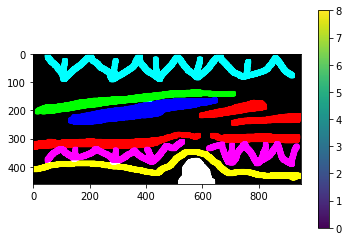

In [120]:
#plt.imshow((mask_il_239.T+segy_data_239.T)*0.5, vmin=0, vmax=8, interpolation='bicubic')
plt.imshow(mask1, interpolation='bicubic', vmin=0, vmax=8)
plt.colorbar()

In [121]:
# Function for example creating
# Outputs a dictionary with pairs of cube tuples and labels
def ex_create(adr_arr,seis_arr,seis_spec,num_examp,cube_incr,inp_res=np.float64,sort_adr = False,replace_illegals = True):
    # adr_arr: 4-column numpy matrix that holds a header in the first row, then adress and class information for examples
    # seis_arr: 3D numpy array that holds a seismic cube
    # seis_spec: object that holds the specifications of the seismic cube;
    # num_examp: the number of output mini-cubes that should be created
    # cube_incr: the number of increments included in each direction from the example to make a mini-cube
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)
    # sort_adr: boolean; whether or not to sort the randomly drawn adresses before making the example cubes
    # replace_illegals: boolean; whether or not to draw a new sample in place for an illegal one, or not

    # Define the cube size
    cube_size = 2*cube_incr+1

    # Define some boundary parameters given in the input object
    inline_start = seis_spec.inl_start
    inline_end = seis_spec.inl_end
    inline_step = seis_spec.inl_step
    #
    xline_start = seis_spec.xl_start
    xline_end = seis_spec.xl_end
    xline_step = seis_spec.xl_step
    #
    t_start = seis_spec.t_start
    t_end = seis_spec.t_end
    t_step = seis_spec.t_step
    #
    num_channels = seis_spec.cube_num

    # Define the buffer zone around the edge of the cube that defines the legal/illegal adresses
    inl_min = inline_start + inline_step*cube_incr
    inl_max = inline_end - inline_step*cube_incr
    #
    xl_min = xline_start + xline_step*cube_incr
    xl_max = xline_end - xline_step*cube_incr
    #
    t_min = t_start + t_step*cube_incr
    t_max = t_end - t_step*cube_incr

    # Print the buffer zone edges
    print('Defining the buffer zone:')
    print('(inl_min,','inl_max,','xl_min,','xl_max,','t_min,','t_max)')
    print('(',inl_min,',',inl_max,',',xl_min,',',xl_max,',',t_min,',',t_max,')')
    
    # Also give the buffer values in terms of indexes
    print('(',cube_incr,',',((inline_end-inline_start)//inline_step) - cube_incr,\
          ',',cube_incr,',',((xline_end-xline_start)//xline_step) - cube_incr,\
          ',',cube_incr,',',((t_end-t_start)//t_step) - cube_incr,')')

    # We preallocate the function outputs; a list of examples and a list of labels
    examples = np.empty((num_examp,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
    labels = np.empty(num_examp,dtype=np.int8)

    # If we want to stack the examples in the third dimension we use the following example preallocation in stead
    # examples = np.empty((num_examp*(cube_size),(cube_size),(cube_size)),dtype=inp_res)

    # Generate a random list of indexes to be drawn, and make sure it only takes a legal amount of examples
    try:
        max_row_idx = len(adr_arr)-1
        rand_idx = random.sample(range(0, max_row_idx), num_examp)
        # NOTE: Could be faster to sort indexes before making examples for algorithm optimization
        if sort_adr:
            rand_idx.sort()
    except ValueError:
        print('Sample size exceeded population size.')

    # Make an iterator for when the lists should become shorter(if we have replacement of illegals or not)
    n=0
    for i in range(num_examp):
        # Get a random in-line, x-line, and time value, and store the label
        # Make sure there is room for an example at this index
        for j in range(50):
            adr = adr_arr[rand_idx[i]]
            # Check that the given example is within the legal zone
            if (adr[0]>=inl_min and adr[0]<inl_max) and \
                (adr[1]>=xl_min and adr[1]<xl_max) and \
                (adr[2]>=t_min and adr[2]<t_max):
                # Make the example for the given address
                # Convert the adresses to indexes and store the examples in the 4th dimension
                idx = [(adr[0]-inline_start)//inline_step,(adr[1]-xline_start)//xline_step,(adr[2]-t_start)//t_step]


                examples[i-n,:,:,:,:] = seis_arr[idx[0]-cube_incr:idx[0]+cube_incr+1,\
                                                 idx[1]-cube_incr:idx[1]+cube_incr+1,\
                                                 idx[2]-cube_incr:idx[2]+cube_incr+1,:]

                # Put the cube and label into the lists
                labels[i-n] = adr[-1]

                # Alternatively; stack the examples in the third dimension
                #datasets[(i-n)*(cube_size):(i-n+1)*(cube_size),:,:] = ex
                break
            else:
                # If we want to replace the illegals, draw again
                if replace_illegals:
                    rand_idx[i] = random.randint(0,max_row_idx)
                else:
                    # if not, just make the output lists shorter
                    n += 1
                    break

            if j == 50:
                # If we can't get a proper cube in 50 consequtive tries
                print('Badly conditioned dataset!')

    # Slice the data if desired
    #labels = labels[0:i-n+1]
    #examples = examples[0:i-n+1,:,:,:]

    # Return the output list/tuple (slice it if it has been shortened)
    return (examples[0:i-n+1,:,:,:,:], labels[0:i-n+1])

In [122]:
# Function that takes the epoch as input and returns the desired learning rate
def adaptive_lr(input_int):
    # input_int: the epoch that is currently being entered

    # define the learning rate (quite arbitrarily decaying)
    lr = 0.1**input_int

    #return the learning rate
    return lr


# Make the network structure and outline, and train it
def train_model(segy_obj,class_array,num_classes,cube_incr,inp_res = np.float64,\
                num_bunch = 10,num_epochs = 100,num_examples = 10000,batch_size = 32,\
                opt_patience = 5, data_augmentation=False,num_channels = 1,\
                keras_model = None,write_out = False,write_location = 'default_write'):
    # segy_obj: Object returned from the segy_decomp function
    # class_array: numpy array of class adresses and type, returned from the convert function
    # num_classes: number of destinct classes we are training on
    # cube_incr: number of increments included in each direction from the example to make a mini-cube
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)
    # num_bunch: number of times we draw a new ensemble of training data and train on it
    # num_epochs: number of epochs we train on a given ensemble of training data
    # num_examples: number of examples we draw in an ensemble
    # batch_size: number of mini-batches we go through at a time from the number of examples
    # opt_patience: epochs that can pass without improvement in accuracy before the system breaks the loop
    # data_augmentation: boolean which determines whether or not to apply augmentation on the examples
    # num_channels: number of segy-cubes we have imported simultaneously
    # keras_model: existing keras model to be improved if the user wants to improve and not create a new model
    # write_out: boolean; save the trained model to disk or not,
    # write_location: desired location on the disk for the model to be saved

    # Check if the user wants to make a new model, or train an existing input model
    if keras_model == None:
        # Begin setting up model architecture and parameters
        cube_size = 2*cube_incr+1

        #  This model is loosely built after that of Anders Waldeland (5 Convolutional layers
        #  and 2 fully connected layers with rectified linear and softmax activations)
        # We have added drop out and batch normalization our selves, and experimented with multi-prediction
        model = Sequential()
        model.add(Conv3D(50, (5, 5, 5), padding='same', input_shape=(cube_size,cube_size,cube_size,num_channels), \
                         strides=(4, 4, 4), data_format="channels_last",name = 'conv_layer1'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv3D(50, (3, 3, 3), strides=(2, 2, 2), padding = 'same',name = 'conv_layer2'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv3D(50, (3, 3, 3), strides=(2, 2, 2), padding= 'same',name = 'conv_layer3'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv3D(50, (3, 3, 3), strides=(2, 2, 2), padding= 'same',name = 'conv_layer4'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv3D(50, (3, 3, 3), strides=(2, 2, 2), padding= 'same',name = 'conv_layer5'))
        model.add(Flatten())
        model.add(Dense(50,name = 'dense_layer1'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(10,name = 'attribute_layer'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(num_classes, name = 'pre-softmax_layer'))
        model.add(BatchNormalization())
        model.add(Activation('softmax'))

        # initiate the Adam optimizer with a given learning rate (Note that this is adapted later)
        opt = keras.optimizers.adam(lr=0.001)

        # Compile the model with the desired loss, optimizer, and metric
        model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    else:
        # Define the model we are performing training on as the input model
        model = keras_model

    ### Begin actual model training
    # Define some initial parameters, and the early stopping and adaptive learning rate callback
    early_stopping = EarlyStopping(monitor='acc', patience=opt_patience)
    LR_sched = LearningRateScheduler(schedule = adaptive_lr)

    # Potential for adding tensor board functionality to see the change of parameters with time
    #tensor_board = TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=32,\
    #                            write_graph=True, write_grads=True, write_images=True,\
    #                            embeddings_freq=1, embeddings_layer_names=None, embeddings_metadata=None)

    # Start the timer for the training iterations
    start = time.time()

    # Train the model
    for i in range(num_bunch):
        # Give an update as to how many times we have drawn a new example set
        print('Iteration number:',i+1,'/',num_bunch)

        # Make the examples
        print('Starting training data creation:')
        (x_train, y_train) = ex_create(adr_arr = class_array,
                                       seis_arr = segy_obj.data,
                                       seis_spec = segy_obj,
                                       num_examp = num_examples,
                                       cube_incr = cube_incr,
                                       inp_res = inp_res,
                                       sort_adr = False,
                                       replace_illegals = True)

        print('Finished creating',num_examples,'examples!')

        # Define and reshape the training data
        # x_train = np.expand_dims(x_train,axis=4)

        # Convert labels to one-hot encoding(and if necessary change the data type and scale as needed)
        y_train = keras.utils.to_categorical(y_train, num_classes)

        # See if the user has chosen to implement data_augmentation and implement it if so
        if not data_augmentation:
            print('Not using data augmentation.')
            # Run the model training
            history = model.fit(x=x_train,
                                y=y_train,
                                batch_size=batch_size,
                                validation_split=0.2,
                                callbacks=[early_stopping, LR_sched],
                                epochs=num_epochs,
                                shuffle=True)

        else:
            # !!! Currently does not work
            print('Using real-time data augmentation.')
            # This will do preprocessing and realtime data augmentation
            datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                                         samplewise_center=False,  # set each sample mean to 0
                                         featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                         samplewise_std_normalization=False,  # divide each input by its std
                                         zca_whitening=False,  # apply ZCA whitening
                                         rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
                                         width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                         height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                                         horizontal_flip=True,  # randomly flip images
                                         vertical_flip=False,    # randomly flip images
                                         shear_range = 0.349, # shear intensity (counter-clockwise direction in radians)
                                         zoom_range = 0.2,   # range for random zoom (float)
                                         rescale = 1.5)  # rescaling factor which multiplies data by the value provided

            # Compute quantities required for feature-wise normalization
            # (std, mean, and principal components if ZCA whitening is applied).
            datagen.fit(x_train)

            # Fit the model on the batches generated by datagen.flow().
            history = model.fit_generator(datagen.flow(x_train,
                                                       y_train,
                                                       batch_size = batch_size),
                                          steps_per_epoch = x_train.shape[0] // batch_size,
                                          epochs = num_epochs,
                                          validation_data = (x_test, y_test))

        # Print the training summary
        print(model.summary())



        # Set the time for one training iteration
        if i == 0:
            end = time.time()
            tot_time = (end-start)*num_bunch



        # Give an update on the time remaining
        rem_time = ((num_bunch-(i+1))/num_bunch)*tot_time

        if rem_time <= 300:
            print('Approximate time remaining of the training:',rem_time,' sec.')
        elif 300 < rem_time <= 60*60:
            minutes = rem_time//60
            seconds = (rem_time%60)*(60/100)
            print('Approximate time remaining of the training:',minutes,' min., ',seconds,' sec.')
        elif 60*60 < rem_time <= 60*60*24:
            hours = rem_time//(60*60)
            minutes = (rem_time%(60*60))*(1/60)*(60/100)
            print('Approximate time remaining of the training:',hours,' hrs., ',minutes,' min., ')
        else:
            days = time_rem//(24*60*60)
            hours = (time_rem%(24*60*60))*(1/60)*((1/60))*(24/100)
            print('Approximate time remaining of the training:',days,' days, ',hours,' hrs., ')


    # Save the trained model if the user has chosen to do so
    if write_out:
        print('Saving model: ...')
        model.save(write_location + '.h5')
        print('Model saved.')


    # Return the trained model
    return model

In [123]:
### ---- Functions for the prediction part of the program ----
# Parse the cube into sub-cubes suitable as model input
def cube_parse(seis_arr,cube_incr,inp_res = np.float64, mode = 'trace', padding = False,\
               conc = False, inline_num = 0, xline_num = 0, depth = 0):
    # seis_arr: a 3D numpy array that holds a seismic cube
    # cube_incr: number of increments included in each direction from the example to make a mini-cube
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)
    # mode: how much of the 3D-cube should be converted to examples ('full','xline','inline','trace', or 'point')
    # padding: do we want to pad the zone which is outside our buffer with zeroes?
    # conc: do we want to concattenate the examples, or store them in the same matrix they were fed to us?
    # inline_num: if mode is inline or point; what inline do we use?
    # xline_num: if mode is xline or point; what xline do we use?
    # depth: if mode is point; what depth do we use?

    # Make some initial definitions wrt. dimensionality
    inls = seis_arr.shape[0]
    xls = seis_arr.shape[1]
    zls = seis_arr.shape[2]
    num_channels = seis_arr.shape[3]
    #
    cube_size = 2*cube_incr+1

    # Define the indent where the saved data will start, if user wants padding this is 0, else it is cube_incr
    if padding:
        i_re = 0
        x_re = 0
        z_re = 0
        # Preallocate the output array, if concatenated it's 4 dimensional, if not it's 6 dimensional
        if conc:
            # Make adjustments to the parameters so that we iterate over the right number of samples, etc.
            if mode == 'full':
                examples = np.zeros((inls*xls*zls,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
            elif mode == 'inline':
                examples = np.zeros((xls*zls,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                x_re = cube_incr
            elif mode == 'xline':
                examples = np.zeros((inls*zls,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                i_re = cube_incr
            elif mode == 'trace':
                examples = np.zeros((zls,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                i_re = cube_incr
                x_re = cube_incr
            elif mode == 'point':
                examples = np.zeros((1,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                i_re = cube_incr
                x_re = cube_incr
                z_re = cube_incr
            else:
                print('ERROR: invalid mode! use: ''full'',''xline'',''inline'',''trace'', or ''point''')
            # Take into account that we will have a total smaller dimensionality of data due to illegals
            inls -= 2*cube_incr
            xls -= 2*cube_incr
            zls -= 2*cube_incr
        else:
            # Make adjustments to the parameters so that we iterate over the right number of samples, etc.
            if mode == 'full':
                examples = np.zeros((inls,xls,zls,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
            elif mode == 'inline':
                examples = np.zeros((1,xls,zls,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                x_re = cube_incr
            elif mode == 'xline':
                examples = np.zeros((inls,1,zls,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                i_re = cube_incr
            elif mode == 'trace':
                examples = np.zeros((1,1,zls,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                i_re = cube_incr
                x_re = cube_incr
            elif mode == 'point':
                examples = np.zeros((1,1,1,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                i_re = cube_incr
                x_re = cube_incr
                z_re = cube_incr
            else:
                print('ERROR: invalid mode! use: ''full'',''xline'',''inline'',''trace'', or ''point''')
    else:
        i_re = cube_incr
        x_re = cube_incr
        z_re = cube_incr
        # Preallocate the output array, if concatenated it's 5 dimensional, if not it's 7 dimensional
        if conc:
            # Make adjustments to the parameters so that we iterate over the right number of samples, etc.
            if mode == 'full':
                examples = np.empty(((inls-2*cube_incr)*(xls-2*cube_incr)*(zls-2*cube_incr),cube_size,cube_size,cube_size,num_channels),\
                                   dtype=inp_res)
            elif mode == 'inline':
                examples = np.empty(((xls-2*cube_incr)*(zls-2*cube_incr),cube_size,cube_size,cube_size,num_channels),\
                                   dtype=inp_res)
                inline_num -= cube_incr
                xline_num = 0
                depth = 0
            elif mode == 'xline':
                examples = np.empty(((inls-2*cube_incr)*(zls-2*cube_incr),cube_size1,cube_size,cube_size,num_channels),\
                                   dtype=inp_res)
                inline_num = 0
                xline_num -= cube_incr
                depth = 0
            elif mode == 'trace':
                examples = np.empty((zls-2*cube_incr,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                inline_num -= cube_incr
                xline_num -= cube_incr
                depth = 0
            elif mode == 'point':
                examples = np.empty((1,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
                inline_num -= cube_incr
                xline_num -= cube_incr
                depth -= cube_incr
            else:
                print('ERROR: invalid mode! use: ''full'',''xline'',''inline'',''trace'', or ''point''')
            # Take into account that we will have a total smaller dimensionality of data due to illegals
            inls -= 2*cube_incr
            xls -= 2*cube_incr
            zls -= 2*cube_incr
        else:
            if mode == 'full':
                examples = np.empty(((inls-2*cube_incr),(xls-2*cube_incr),(zls-2*cube_incr),cube_size,cube_size,cube_size,num_channels),\
                                   dtype=inp_res)
            elif mode == 'inline':
                examples = np.empty((1,(xls-2*cube_incr),(zls-2*cube_incr),cube_size,cube_size,cube_size,num_channels),\
                                   dtype=inp_res)
            elif mode == 'xline':
                examples = np.empty(((inls-2*cube_incr),1,(zls-2*cube_incr),cube_size,cube_size,cube_size,num_channels),\
                                   dtype=inp_res)
            elif mode == 'trace':
                examples = np.empty((1,1,(zls-2*cube_incr),cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
            elif mode == 'point':
                examples = np.empty((1,1,1,cube_size,cube_size,cube_size,num_channels),dtype=inp_res)
            else:
                print('ERROR: invalid mode! use: ''full'',''xline'',''inline'',''trace'', or ''point''')


    # Iterate through the desired section of the 3D input array, create the example cubes, and store them as desired
    if conc:
        # Make the cubes
        for i in range(cube_incr, inls+cube_incr):
            if mode == 'xline':
                j = xline_num
                for k in range(cube_size, zls+cube_size):
                    examples[inls*(i-i_re)+k-z_re,:,:,:,:] = seis_arr[i-cube_incr+inline_num:i+cube_incr+inline_num+1,\
                                                                      j-cube_incr:j+cube_incr+1,\
                                                                      k-cube_incr+depth:k+cube_incr+depth+1,:]
            else:
                for j in range(cube_incr, xls+cube_incr):
                    for k in range(cube_incr, zls+cube_incr):
                        #print('---------cube_incr={}, inline_num={}\n'.format(cube_incr, inline_num))
                        cc = seis_arr[i-cube_incr+inline_num:i+cube_incr+inline_num+1,\
                                      j-cube_incr+xline_num:j+cube_incr+xline_num+1,\
                                      k-cube_incr+depth:k+cube_incr+depth+1,:]
                        #print(' examples shape:{}, cc shape:{}, z1: {}, z2: {} \n'.format(examples.shape, cc.shape, k-cube_incr+depth, k+cube_incr+depth+1))
                        #
                        examples[(i-i_re)*inls+(j-x_re)*xls+k-z_re,:,:,:,:] = cc

                        # Make sure we stop after the appropriate number of iterations
                        if mode == 'point':
                            break
                    if mode == 'point' or mode == 'trace':
                        break
                if mode == 'point' or mode == 'trace' or mode == 'inline':
                    break


    else:
        # Make the cubes
        for i in range(cube_incr, inls-cube_incr):
            if mode == 'xline':
                for k in range(cube_incr, zls-cube_incr):
                    examples[i-i_re,1,k-z_re,:,:,:,:] = seis_arr[i-cube_incr:i+cube_incr+1,\
                                                                 xline_num-cube_incr:xline_num+cube_incr+1,\
                                                                 k-cube_incr:k+cube_incr+1,:]
            else:
                for j in range(cube_incr, xls-cube_incr):
                    for k in range(cube_incr, zls-cube_incr):
                        examples[i-i_re,j-x_re,k-z_re,:,:,:,:] = seis_arr[i+inline_num-cube_incr:i+inline_num+cube_incr+1,\
                                                                          j+xline_num-cube_incr:j+xline_num+cube_incr+1,\
                                                                          k+depth-cube_incr:k+depth+cube_incr+1,:]

                        # Make sure we stop after the appropriate number of iterations
                        if mode == 'point':
                            break
                    if mode == 'point' or mode == 'trace':
                        break
                if mode == 'point' or mode == 'trace' or mode == 'inline':
                    break


    # Return the list of examples stored as the desired type of array
    return examples



# Make an intermediate output model to check filters
def makeIntermediate(keras_model,layer_name):
    # keras_model: keras model that has been trained previously
    # layer_name: name of the layer with the desired output

    # Define the new model that stops at the desired layer
    intermediate_layer_model = Model(inputs=keras_model.input,\
                                     outputs=keras_model.get_layer(layer_name).output)

    # Return the newly defined model
    return intermediate_layer_model

In [124]:
# Predict the output class of the given input traces
def predicting(filename,inp_seis,seis_obj,keras_model,cube_incr,num_classes,inp_res=np.float64,mode='xline',\
               section=np.asarray([0,0,0,0,0,0]),line_num=0, print_segy = False,savename = 'default_write',\
               pred_batch = 1,show_features = False, layer_name='attribute_layer', show_prob = False):
    # filename: filename of the segy-cube to be imported (necessary for copying the segy-frame before writing a new segy)
    # inp_seis: a 3D numpy array that holds the input seismic cube
    # seis_obj: Object returned from the segy_decomp function
    # keras_model: keras model that has been trained previously
    # cube_incr: number of increments included in each direction from the example to make a mini-cube
    # num_classes: num_classes: number of destinct classes we are training on
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)
    # mode: what part of the cube to predict along; 'inline', 'xline', 'section, or 'full' (entire cube)
    # section: edge locations(index) of the sub-section (min. inline, max. inline, min. xline, max xline, min z, max z)
    # line_num: xline/inline number to predict along
    # print_segy: whether or not to save the prediction as a segy, npy and csv file (previously just segy)
    # savename: name of the files to be saved (extensions are added automatically)
    # pred_batch: number of traces to predict on at a time
    # show_features: whether or not to get the features or the classes
    # layer_name: optionally give a different layer to get the features from (name defined in keras.model)
    # show_prob: if the user wants to get out probabilities or classifications

    # Define some initial parameters
    num_channels = seis_obj.cube_num
    inls = inp_seis.shape[0]
    xls = inp_seis.shape[1]
    zls = inp_seis.shape[2]
    #
    cube_size = 2*cube_incr+1

    # If the user simply wants the classification we only need 1 value for each input point,
    if not show_prob:
        num_classes = 1

    # Read the section needed for prediction depending on the mode
    if mode == 'inline':
        section_edge = np.asarray([line_num,line_num,cube_incr,xls-cube_incr,cube_incr,zls-cube_incr])
    elif mode == 'xline':
        section_edge = np.asarray([cube_incr,inls-cube_incr,line_num,line_num,cube_incr,zls-cube_incr])
    elif mode == 'section':
        section_edge = section
    elif mode == 'full':
        section_edge = np.asarray([cube_incr,inls-cube_incr,cube_incr,xls-cube_incr,cube_incr,zls-cube_incr])
    else:
        print('invalid mode, please input inline, xline, section, or full')

    # Preallocate the full prediction array and if the user wants to show the features make the intermediate model,
    if show_features:
        intermediate_layer_model = Model(inputs=keras_model.input,
                                         outputs=keras_model.get_layer(layer_name).output)
        prediction = np.empty((\
            (section_edge[5]-section_edge[4]+1)*(section_edge[3]-section_edge[2]+1)*(section_edge[1]-section_edge[0]+1),10),\
                              dtype=np.float32)
    else:
        prediction = np.empty((\
            (section_edge[5]-section_edge[4]+1)*(section_edge[3]-section_edge[2]+1)*(section_edge[1]-section_edge[0]+1),\
                               num_classes),dtype=np.float32)

    # Preallocate the data array to fill for each batch and initiate iterators
    data = np.empty((pred_batch*(section_edge[5]-section_edge[4]+1),cube_size,cube_size,cube_size,num_channels), dtype=inp_res)
    indx = 0
    jndx = 0

    # Calculate how many sets of batches need to be done and define parameters needed for the final batch
    tot_len = (section_edge[1]-section_edge[0]+1)*(section_edge[3]-section_edge[2]+1)  # nx0*ny0
    rem = tot_len % pred_batch
    num_it = tot_len // pred_batch
    # Time the sub_prediction
    start = time.time()

    # Start making sub-cubes from the input traces and store then in the data array
    print('Retrieving to memory:')
    for il_num in range(section_edge[0],section_edge[1]+1):
        # Make a progres update for the inline number
        print('inline-num:',il_num-section_edge[0]+1,'/',section_edge[1]-section_edge[0]+1)
        for xl_num in range(section_edge[2],section_edge[3]+1):
            # Make a progres update for the xline number
            print('xline-num:',xl_num-section_edge[2]+1,'/',section_edge[3]-section_edge[2]+1)
            for z_num in range(section_edge[5]-section_edge[4]+1):
                # Call the cube_parse function to get the cubes corresponding to the current point
                data[indx*(section_edge[5]-section_edge[4]+1)+z_num,:,:,:,:] = cube_parse(seis_arr = inp_seis,
                                                                                        cube_incr = cube_incr,
                                                                                        inp_res = inp_res,
                                                                                        mode = 'point',
                                                                                        padding = False,
                                                                                        conc = True,
                                                                                        inline_num = il_num,
                                                                                        xline_num = xl_num,
                                                                                        depth = z_num+section_edge[4])

            # Check if we have filled up the data array and need to do a prediction
            if (indx+1) % pred_batch == 0:
                print('Making prediction on sub-section:')

                # Predict the given class or features dependant on the user input
                if show_features:
                    prediction[jndx*(pred_batch*(section_edge[5]-section_edge[4]+1)):\
                              (jndx+1)*(pred_batch*(section_edge[5]-section_edge[4]+1)),:] = \
                                    intermediate_layer_model.predict((data))

                else:
                    if show_prob:
                        # Simple model prediction with probabilities
                        prediction[jndx*(pred_batch*(section_edge[5]-section_edge[4]+1)):\
                                   (jndx+1)*(pred_batch*(section_edge[5]-section_edge[4]+1)),:] = \
                        keras_model.predict((data))
                    else:
                        # Model prediction of classes
                        prediction[jndx*(pred_batch*(section_edge[5]-section_edge[4]+1)):\
                                   (jndx+1)*(pred_batch*(section_edge[5]-section_edge[4]+1)),:] = \
                        np.expand_dims(keras_model.predict_classes((data)),axis = 1)

                # Tell the user the section is finished
                print('Section finished!')

                if jndx == 0:
                    # Finish the timer and calculate how long the user should expect the program to take:
                    end = time.time()
                    DT = end-start # seconds per iteration
                    tot_time = num_it*DT+(rem/pred_batch)*DT #seconds

                # Give the user an update regarding the time remaining
                time_rem = (tot_time-DT*(jndx+1))
                if time_rem <= 300:
                    print('Approximate time remaining of the prediction:',time_rem, ' sec.')
                elif 300 < time_rem <= 60*60:
                    minutes = time_rem//60
                    seconds = (time_rem%60)*(60/100)
                    print('Approximate time remaining of the prediction:',minutes,' min., ',seconds,' sec.')
                elif 60*60 < time_rem <= 60*60*24:
                    hours = time_rem//(60*60)
                    minutes = (time_rem%(60*60))*(1/60)*(60/100)
                    print('Approximate time remaining of the prediction:',hours,' hrs., ',minutes,' min., ')
                else:
                    days = time_rem//(24*60*60)
                    hours = (time_rem%(24*60*60))*(1/60)*((1/60))*(24/100)
                    print('Approximate time remaining of the prediction:',days,' days, ',hours,' hrs., ')


                # Update iterators and give updates to user
                indx = 0
                jndx+=1
                print('Retrieving to memory:')

            # Check if we have exhausted the range of data to be predicted and need to finish the function
            elif jndx == num_it and indx == rem-1:
                # Slice the data array to only include the relevant part
                data = data[:indx*(section_edge[5]-section_edge[4]+1)+z_num+1]

                print('Finalizing prediction:')

                # Make the final prediction
                if show_features:
                    prediction[jndx*(pred_batch*(section_edge[5]-section_edge[4]+1)):,:] = \
                                    intermediate_layer_model.predict((data))
                else:
                    if show_prob:
                        prediction[jndx*(pred_batch*(section_edge[5]-section_edge[4]+1)):,:] = \
                                    keras_model.predict((data))
                    else:
                        prediction[jndx*(pred_batch*(section_edge[5]-section_edge[4]+1)):,:] = \
                                    np.expand_dims(keras_model.predict_classes((data)),axis = 1)

            # If we should keep filling the data and not predict yet, simply increase the iterator
            else:
                indx+=1

    # Reshape the prediction to the shape of the desired cube
    print('Reshaping prediction:')
    
    # ny0, nx0, nz0, num_classes
    if show_features:
        prediction = prediction.reshape((section_edge[1]-section_edge[0]+1,\
                                         section_edge[3]-section_edge[2]+1,\
                                         section_edge[5]-section_edge[4]+1,10),order='C')
    else:
        prediction = prediction.reshape((section_edge[1]-section_edge[0]+1,\
                                         section_edge[3]-section_edge[2]+1,\
                                         section_edge[5]-section_edge[4]+1,num_classes),order='C')

    print('Prediction finished!', ' shape={}-{}-{}-{}'.format(prediction.shape[0], prediction.shape[1], 
                                                              prediction.shape[2], prediction.shape[3]))

    # Save the prediction as a segy, numpy and csv file
    # NOTE: Everything SEGY and CSV is made into 32bit-float to conform to commonly used reading programs
    if print_segy:
        # Update the data we send to the saver functions dependant on what we have predicted
        if show_prob:
            class_row = 1
        else:
            class_row = 0

        print('Saving prediction: ...')

        # Save the numpy file
        np.save(savename + '.npy', prediction)

        # Get the right filename in case the input is given as a list
        if type(filename) is list:
            # Save the segy file using the input filename as a framework
            # Just use the first member of the list as the reference
            input_file = filename[0]
        else:
            # Save the segy file using the input filename as a framework
            input_file=filename

        output_file=savename + '.sgy'

        copyfile(input_file, output_file)

        with segyio.open( output_file, "r+" ) as src:
            # iterate through each inline and update the values
            i = 0
            for ilno in src.ilines:
                src.iline[ilno] = -1*(np.ones((src.iline[ilno].shape),dtype = np.float32))

                if src.ilines[section_edge[0]] <= ilno <= src.ilines[section_edge[1]]:
                    line = src.iline[ilno]
                    line[section_edge[2]:section_edge[3]+1,section_edge[4]:section_edge[5]+1] = prediction[i,:,:,class_row]
                    src.iline[ilno]=line
                    i += 1

        # Save the csv(ixz) file
        csv_struct(inp_numpy = prediction[:,:,:,class_row],
                   spec_obj = seis_obj,
                   section = section_edge,
                   inp_res = np.float32,
                   save = True,
                   savename = (savename + '.ixz'))

        # Print to the user that the function has finished saving
        print('Prediction saved.')

    # Return the prediction array
    return prediction    

In [125]:
### ---- Functions for visualizing the predictions from the program ----
# Make a plotting function for plotting the features
def plotNNpred(pred,im_per_line,line_num,section):
    # pred: 4D-numpy array with the features in the 4th dimension
    # im_per_line: How many sub plot images to have in each row of the display
    # line_num: what xline to use as a reference
    # section: the section that was used for prediction

    # Define some initial parameters, like the number of features and plot size, etc.
    features = pred.shape[3]
    plt.figure(2, figsize=(20,20))
    n_columns = im_per_line
    n_rows = math.ceil(features / n_columns) + 1

    # Itterate through the sub-plots and fill them with the features, do some simple formatting
    for i in range(features):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Feature ' + str(i+1))
        plt.imshow(pred[:,line_num-1,:,i].T, interpolation="nearest", cmap="rainbow",\
                   extent=[section[0],section[1],-section[5],-section[4]])
        plt.colorbar()

In [126]:
# Make and visualize the predicted data
def visualization(filename,inp_seis,seis_obj,keras_model,cube_incr,section_edge,xline_ref,num_classes,\
                  inp_res=np.float64,sect_form = None,save_pred = False, save_file = 'default_write', \
                  pred_batch = 1,show_feature = False, show_prob = True):
    # filename: filename of the segy-cube to be imported (necessary for copying the segy-frame before writing a new segy)
    # inp_seis: a 3D numpy array that holds the input seismic cube
    # seis_obj: Object returned from the segy_decomp function
    # keras_model: keras model that has been trained previously
    # cube_incr: number of increments included in each direction from the example to make a mini-cube
    # section_edge: edge locations of the sub-section; either index or (min. inline, max. inline, min. xline, max xline, min z, max z)
    # xline_ref: reference crossline from the original seismic cube to be plotted with the prediction (must be within section)
    # num_classes: number of classes to be predicted
    # inp_res: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)
    # sect_form: formatting of the section edges (if 'segy' we have to convert iline,xline,time to indexes)
    # save_pred: whether or not to save the prediction as a segy, numpy and csv(ixz) file.
    # save_file: name of the files to be saved (extensions are added automatically)
    # pred_batch: number of traces to predict on at a time
    # show_features: whether or not to get the features or the classes
    # show_prob: if the user wants to get out probabilities or classifications



    # Adjust the section numbering and reference xline from inline-xline-time to index if this is given in segy format
    if sect_form == 'segy':
        section_edge[0] = (section_edge[0] - seis_obj.inl_start)//seis_obj.inl_step
        section_edge[1] = (section_edge[1] - seis_obj.inl_start)//seis_obj.inl_step
        #
        section_edge[2] = (section_edge[2] - seis_obj.xl_start)//seis_obj.xl_step
        section_edge[3] = (section_edge[3] - seis_obj.xl_start)//seis_obj.xl_step
        #
        section_edge[4] = (section_edge[4] - seis_obj.t_start)//seis_obj.t_step
        section_edge[5] = (section_edge[5] - seis_obj.t_start)//seis_obj.t_step
        #
        xline_ref = (xline_ref - seis_obj.xl_start)//seis_obj.xl_step
        
    # after inline/xline conversion
    print(' Partial section geometry: ')
    print('ils=', section_edge[0], 'ile=', section_edge[1])
    print('xls=', section_edge[2], 'xle=', section_edge[3])
    print('zls=', section_edge[4], 'zle=', section_edge[5])
    print('xline_ref={}\n'.format(xline_ref))

    #
    assert xline_ref > cube_incr and xline_ref < inp_seis.shape[1]-cube_incr, " xline is too small or too big"
    
    # 
    print(' inp_seis shape=', inp_seis.shape, ' cube_incr=', cube_incr)
    
    # adjustment 
    if section_edge[0] < cube_incr:
        section_edge[0] = cube_incr
    if section_edge[2] < cube_incr:
        section_edge[2] = cube_incr
    if section_edge[4] < cube_incr:
        section_edge[4] = cube_incr
    #
    if section_edge[1] >= inp_seis.shape[0] - cube_incr:
        section_edge[1] = inp_seis.shape[0] - cube_incr -1
    if section_edge[3] >= inp_seis.shape[1] - cube_incr:
        section_edge[3] = inp_seis.shape[1] - cube_incr -1
    if section_edge[5] >= inp_seis.shape[2] - cube_incr:
        section_edge[5] = inp_seis.shape[2] - cube_incr -1
        
    # after inline/xline conversion
    print(' After adjustment, partial section geometry: ')
    print('ils=', section_edge[0], 'ile=', section_edge[1])
    print('xls=', section_edge[2], 'xle=', section_edge[3])
    print('zls=', section_edge[4], 'zle=', section_edge[5])
    
    # Make the prediction
    pred = predicting(filename=filename,
                      inp_seis=inp_seis,
                      seis_obj=seis_obj,
                      keras_model=keras_model,
                      cube_incr=cube_incr,
                      num_classes = num_classes,
                      inp_res = inp_res,
                      mode='section',
                      section=section_edge,
                      line_num=xline_ref,
                      print_segy=save_pred,
                      savename=save_file,
                      pred_batch = pred_batch,
                      show_features=show_feature,
                      layer_name='attribute_layer',
                      show_prob = show_prob)

    # Define some parameters used for getting nice plots(range of c-axis, and which row to show in the prediction)
    features = pred.shape[2]
    if show_prob:
        class_row = 1
        c_max = 1
    else:
        class_row = 0
        c_max = num_classes-1

    # Visualize the results from the prediction, either with features or classes/probabilities
    if show_feature:
        # Make the figure object/handle and plot the reference xline
        plt.figure(1, figsize=(15,15))
        plt.title('x-line')
        plt.imshow(inp_seis[cube_incr:-cube_incr,xline_ref,cube_incr:-cube_incr].T,interpolation="nearest",\
                   cmap="gray",extent=[cube_incr,-cube_incr+len(inp_seis),cube_incr-len(inp_seis[0,0]),-cube_incr])

        # Plot all the features and show the figures
        plotNNpred(pred,5,xline_ref-section_edge[2]+1,section_edge)
        plt.show()

    else:
        # Make the figure object/handle and plot the reference xline
        plt.figure(1, figsize=(15,15))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
        plt.subplot(gs[0])
        plt.title('x-line: {}'.format(xline_ref))
        plt.imshow(inp_seis[cube_incr:-cube_incr,xline_ref,cube_incr:-cube_incr, 0].T,interpolation="nearest",\
           cmap="gray",extent=[cube_incr,-cube_incr+len(inp_seis),cube_incr-len(inp_seis[0,0]),-cube_incr])
        plt.colorbar()

        # Plot the probability/classification and show the figures
        plt.subplot(gs[1])
        plt.title('classification/probability of 1,x-line: {}'.format(xline_ref))
        pred0 = np.squeeze(pred[:, :, :,class_row])
        print(' prediction shape={}-{}-{}-{}'.format(pred.shape[0], pred.shape[1], 
                                                     pred.shape[2], pred.shape[3]))
        plt.imshow(pred0.T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))
                        
        plt.colorbar()
        plt.show()

    # Return the predicted numpy cube
    return pred

In [127]:
# Rough function to show more detailed plots of the predictions in python for QC before going to Petrel
def show_details(filename,cube_incr,predic,inline,inl_start,xline,xl_start,\
                 slice_number,slice_incr,inp_format=np.float64,show_prob = True,num_classes = 2):
    # filename: filename of the segy-cube to be imported (necessary for copying the segy-frame before writing a new segy)
    # cube_incr: number of increments included in each direction from the example to make a mini-cube
    # predic: numpy cube holding the prediction
    # inline: inline number to center our visualization on
    # inl_start: index of the first inline in the prediction
    # xline: xline number to center our visualization on
    # xl_start: index of the first xline in the prediction
    # slice_number: depth slice number to center our visualization on
    # slice_incr: increments to take in depth between each plot
    # inp_format: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)
    # show_prob: if the user wants to get out probabilities or classifications
    # num_classes: number of classes that was predicted


    # Read out the reference segy object
    segy_obj = segy_decomp(segy_file = filename,
                           plot_data = False,
                           read_direc = 'xline',
                           inp_res = inp_format)

    # Get the numpy cube from the reference segy object
    inp_seis = segy_obj.data

    # define some parameters used for getting nice plots(range of c-axis, and which row to show in the prediction)
    if show_prob:
        class_row = 1
        c_max = 1
    else:
        class_row = 0
        c_max = num_classes-1

    # Make the figure object/handle and plot the reference xline
    plt.figure(1, figsize=(20,15))
    plt.subplot(1, 8, 1)
    plt.title('xline: ' + str(xline))
    plt.imshow(inp_seis[inline-cube_incr:inline+cube_incr,xline,cube_incr:-cube_incr].T,interpolation="nearest", cmap="gray")
    plt.colorbar()

    # Plot the prediciton for the reference xline along with 3 increments in each direction
    plt.subplot(1, 8, 2)
    plt.title('xline - 3')
    plt.imshow(predic[:,xline-xl_start - 3,:,class_row].T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))
    
    plt.subplot(1, 8, 3)
    plt.title('xline')
    plt.imshow(predic[:,xline-xl_start,:,class_row].T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))

    plt.subplot(1, 8, 4)
    plt.title('xline + 3')
    plt.imshow(predic[:,xline-xl_start + 3,:,class_row].T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))
    plt.colorbar()
    
    # Plot the reference inline
    plt.subplot(1, 8, 1+4)
    plt.title('inline: ' + str(inline))
    plt.imshow(inp_seis[inline,xline-cube_incr:xline+cube_incr,cube_incr:-cube_incr].T,interpolation="nearest", cmap="gray")
    plt.colorbar()

    # Plot the prediciton for the reference inline along with 3 increments in each direction
    plt.subplot(1, 8, 2+4)
    plt.title('inline - 3')
    plt.imshow(predic[inline-inl_start-3,:,:,class_row].T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))

    plt.subplot(1, 8, 3+4)
    plt.title('inline')
    plt.imshow(predic[inline-inl_start,:,:,class_row].T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))

    plt.subplot(1, 8, 4+4)
    plt.title('inline + 3')
    plt.imshow(predic[inline-inl_start+3,:,:,class_row].T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))
    plt.colorbar()

    # Make a new figure object/handle and plot 3 reference depth slices
    plt.figure(2, figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.title('slice - ' + str(slice_incr))
    plt.imshow(inp_seis[inline-cube_incr:inline+cube_incr,xline-cube_incr:xline+cube_incr,cube_incr+slice_number-slice_incr].T,\
               interpolation="nearest", cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title('slice: ' + str(slice_number))
    plt.imshow(inp_seis[inline-cube_incr:inline+cube_incr,xline-cube_incr:xline+cube_incr,cube_incr+slice_number].T,\
               interpolation="nearest", cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title('slice + ' + str(slice_incr))
    plt.imshow(inp_seis[inline-cube_incr:inline+cube_incr,xline-cube_incr:xline+cube_incr,cube_incr+slice_number+slice_incr].T,\
               interpolation="nearest", cmap="gray")
    plt.colorbar()

    # Make a new figure object/handle and plot the 3 corresponding predicted depth slices
    plt.figure(3, figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.title('slice - ' + str(slice_incr))
    plt.imshow(predic[:,:,slice_number-slice_incr,class_row].T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))

    plt.subplot(1, 3, 2)
    plt.title('slice: ' + str(slice_number))
    plt.imshow(predic[:,:,slice_number,class_row].T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))

    plt.subplot(1, 3, 3)
    plt.title('slice + ' + str(slice_incr))
    plt.imshow(predic[:,:,slice_number+slice_incr,class_row].T,interpolation="nearest", cmap="gist_rainbow", clim=(0.0, c_max))
    plt.colorbar()
    plt.show()

In [128]:
### ---- MASTER/MAIN function ----
# Make an overall master function that takes inn some basic parameters,
# trains, predicts, and visualizes the results from a model
def master(segy_filename,inp_format,cube_incr,train_dict={},pred_dict={},mode = 'full'):
    # segy_filename: filename of the segy-cube to be imported (necessary for copying the segy-frame before writing a new segy)
    # inp_format: input resolution, the formatting of the seismic cube (could be changed to 8-bit data)
    # cube_incr: number of increments included in each direction from the example to make a mini-cube
    # train_dict: Training parameters packaged as a Python dictionary
    # pred_dict: Prediciton parameters packaged as a Python dictionary
    # mode: Do we want to train a model('train'), predict using an external model('predict'), or train a model and predict using it('full')

    # Implement more than one segy-cube if the input segy_filename is a list
    if type(segy_filename) is str or (type(segy_filename) is list and len(segy_filename) == 1):
        # Check if the filename needs to be retrieved from a list
        if type(segy_filename) is list:
            segy_filename = segy_filename[0]

        # Make a master segy object
        segy_obj = segy_decomp(segy_file = segy_filename,
                               plot_data = False,
                               read_direc = 'full',
                               inp_res = inp_format)

        # Define how many segy-cubes we're dealing with
        segy_obj.cube_num = 1
        segy_obj.data = np.expand_dims(segy_obj.data, axis = 4)

    elif type(segy_filename) is list:
        # start an iterator
        i = 0

        # iterate through the list of cube names and store them in a masterobject
        for filename in segy_filename:
            # Make a master segy object
            if i == 0:
                segy_obj = segy_decomp(segy_file = filename,
                                       plot_data = False,
                                       read_direc = 'full',
                                       inp_res = inp_format)

                # Define how many segy-cubes we're dealing with
                segy_obj.cube_num = len(segy_filename)

                # Reshape and preallocate the numpy-array for the rest of the cubes
                print('Starting restructuring to 4D arrays')
                ovr_data = np.empty((list(segy_obj.data.shape) + [len(segy_filename)]))
                ovr_data[:,:,:,i] = segy_obj.data
                segy_obj.data = ovr_data
                ovr_data = None
                print('Finished restructuring to 4D arrays')
            else:
                # Add another cube to the numpy-array
                segy_obj.data[:,:,:,i] = segy_adder(segy_file = filename,
                                                    inp_cube = segy_obj.data,
                                                    read_direc = 'full',
                                                    inp_res = inp_format)
            # Increase the itterator
            i+=1
    else:
        print('The input filename needs to be a string, or a list of strings')


    print('Finished unpaking and restructuring the numpy array')


    # Are we going to perform training?
    if mode == 'train' or mode == 'full':
        # Unpack the dictionary of training parameters
        label_list = train_dict['files']
        num_bunch = train_dict['num_tot_iterations']
        num_epochs = train_dict['epochs']
        num_examples = train_dict['num_train_ex']
        batch_size = train_dict['batch_size']
        opt_patience = train_dict['opt_patience']
        data_augmentation = train_dict['data_augmentation']
        write_out = train_dict['save_model']
        write_location = train_dict['save_location']

        # If there is a model given in the prediction dictionary continue training on this model
        if 'keras_model' in pred_dict:
            keras_model = pred_dict['keras_model']
        else:
            keras_model = None

        # Print out an initial statement to confirm the parameters(QC)
        print('num full iterations:', num_bunch)
        print('num epochs:',num_epochs)
        print('num examples per epoch:',num_examples)
        print('batch size:',batch_size)
        print('optimizer patience:',opt_patience)


        # Make the list of class data
        print('Making class-adresses')
        class_array = convert(file_list = label_list,
                              save = False,
                              savename = None,
                              ex_adjust = True)

        print('Finished making class-adresses')

        # Time the training process
        start_train_time = time.time()

        # Train a new model/further train the uploaded model and store the result as the model output
        model = train_model(segy_obj = segy_obj,
                            class_array = class_array,
                            num_classes = len(label_list),
                            cube_incr = cube_incr,
                            inp_res = inp_format,
                            num_bunch = num_bunch,
                            num_epochs = num_epochs,
                            num_examples = num_examples,
                            batch_size = batch_size,
                            opt_patience = opt_patience,
                            data_augmentation = data_augmentation,
                            num_channels = segy_obj.cube_num,
                            keras_model = keras_model,
                            write_out = write_out,
                            write_location = write_location)

        # Time the training process
        end_train_time = time.time()
        train_time = end_train_time-start_train_time # seconds

        # print to the user the total time spent training
        if train_time <= 300:
            print('Total time elapsed during training:',train_time, ' sec.')
        elif 300 < train_time <= 60*60:
            minutes = train_time//60
            seconds = (train_time%60)*(60/100)
            print('Total time elapsed during training:',minutes,' min., ',seconds,' sec.')
        elif 60*60 < train_time <= 60*60*24:
            hours = train_time//(60*60)
            minutes = (train_time%(60*60))*(1/60)*(60/100)
            print('Total time elapsed during training:',hours,' hrs., ',minutes,' min., ')
        else:
            days = train_time//(24*60*60)
            hours = (train_time%(24*60*60))*(1/60)*((1/60))*(24/100)
            print('Total time elapsed during training:',days,' days, ',hours,' hrs., ')

    elif mode == 'predict':
        # If we aren't performing any training
        print('Using uploaded model for prediction')
    else:
        print('Invalid mode! Accepted inputs are ''train'', ''predict'', or ''full''')
        return None

    # Are we going to perform prediction?
    if mode == 'predict' or mode == 'full':
        # Let the user know if we have made new computations on the model used for prediction
        if mode == 'full':
            print('Using the newly computed model for prediction')
        else:
            model  = pred_dict['keras_model']

        # Unpack the prediction dictionary
        section_edge  = pred_dict['section_edge']  # np.asarray([339, 339, xls, xle, ts, te])
        xline_ref = pred_dict['xline']
        num_classes = pred_dict['num_class']
        sect_form = pred_dict['cord_syst']            # 'segy'
        show_feature  = pred_dict['show_feature']
        save_pred = pred_dict['save_pred']
        save_loc = pred_dict['save_location']
        pred_batch = pred_dict['pred_batch']
        prob = pred_dict['pred_prob']

        # Time the prediction process
        start_pred_time = time.time()

        # Make a prediction on the master segy object using the desired model, and plot the results
        pred = visualization(filename = segy_filename,
                             inp_seis = segy_obj.data,
                             seis_obj = segy_obj,
                             keras_model = model,
                             cube_incr = cube_incr,
                             section_edge = section_edge,
                             xline_ref = xline_ref,
                             num_classes = num_classes,
                             inp_res = inp_format,
                             sect_form = sect_form,
                             save_pred = save_pred,
                             save_file = save_loc,
                             pred_batch = pred_batch,
                             show_feature = show_feature,
                             show_prob = prob)

        # Print the time taken for the prediction
        end_pred_time = time.time()
        pred_time = end_pred_time-start_pred_time # seconds

        # print to the user the total time spent training
        if pred_time <= 300:
            print('Total time elapsed during prediction:',pred_time, ' sec.')
        elif 300 < pred_time <= 60*60:
            minutes = pred_time//60
            seconds = (pred_time%60)*(60/100)
            print('Total time elapsed during prediction:',minutes,' min., ',seconds,' sec.')
        elif 60*60 < pred_time <= 60*60*24:
            hours = pred_time//(60*60)
            minutes = (pred_time%(60*60))*(1/60)*(60/100)
            print('Total time elapsed during prediction:',hours,' hrs., ',minutes,' min., ')
        else:
            days = pred_time//(24*60*60)
            hours = (pred_time%(24*60*60))*(1/60)*((1/60))*(24/100)
            print('Total time elapsed during prediction:',days,' days, ',hours,' hrs., ')

    else:
        # Make an empty variable for the prediction output
        pred = None

    # Return the new model and/or prediction as an output dictionary
    output = {
        'model' : model,
        'pred' : pred
    }

    return output

Starting SEG-Y decompressor
 SEGY inline/xline/t geometry:
 ils=100, ile=750, ili=1, ilen=651

 xls=300, xle=1250, xli=1, xlen=951

 ts=4, te=1848, ti=4

Finished using the SEG-Y decompressor
Finished unpaking and restructuring the numpy array
Using uploaded model for prediction
 Partial section geometry: 
ils= 239 ile= 239
xls= 0 xle= 950
zls= 0 zle= 461
xline_ref=100

 inp_seis shape= (651, 951, 462, 1)  cube_incr= 32
 After adjustment, partial section geometry: 
ils= 239 ile= 239
xls= 32 xle= 918
zls= 32 zle= 429
Retrieving to memory:
inline-num: 1 / 1
xline-num: 1 / 887
xline-num: 2 / 887
xline-num: 3 / 887


/home/hzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:26: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


xline-num: 4 / 887
xline-num: 5 / 887
xline-num: 6 / 887
xline-num: 7 / 887
xline-num: 8 / 887
xline-num: 9 / 887
xline-num: 10 / 887
xline-num: 11 / 887
xline-num: 12 / 887
xline-num: 13 / 887
xline-num: 14 / 887
xline-num: 15 / 887
xline-num: 16 / 887
xline-num: 17 / 887
xline-num: 18 / 887
xline-num: 19 / 887
xline-num: 20 / 887
xline-num: 21 / 887
xline-num: 22 / 887
xline-num: 23 / 887
xline-num: 24 / 887
xline-num: 25 / 887
Making prediction on sub-section:
Section finished!
Approximate time remaining of the prediction: 22.0  min.,  10.00584534072882  sec.
Retrieving to memory:
xline-num: 26 / 887
xline-num: 27 / 887
xline-num: 28 / 887
xline-num: 29 / 887
xline-num: 30 / 887
xline-num: 31 / 887
xline-num: 32 / 887
xline-num: 33 / 887
xline-num: 34 / 887
xline-num: 35 / 887
xline-num: 36 / 887
xline-num: 37 / 887
xline-num: 38 / 887
xline-num: 39 / 887
xline-num: 40 / 887
xline-num: 41 / 887
xline-num: 42 / 887
xline-num: 43 / 887
xline-num: 44 / 887
xline-num: 45 / 887
xline-num

xline-num: 310 / 887
xline-num: 311 / 887
xline-num: 312 / 887
xline-num: 313 / 887
xline-num: 314 / 887
xline-num: 315 / 887
xline-num: 316 / 887
xline-num: 317 / 887
xline-num: 318 / 887
xline-num: 319 / 887
xline-num: 320 / 887
xline-num: 321 / 887
xline-num: 322 / 887
xline-num: 323 / 887
xline-num: 324 / 887
xline-num: 325 / 887
Making prediction on sub-section:
Section finished!
Approximate time remaining of the prediction: 14.0  min.,  18.885481533050598  sec.
Retrieving to memory:
xline-num: 326 / 887
xline-num: 327 / 887
xline-num: 328 / 887
xline-num: 329 / 887
xline-num: 330 / 887
xline-num: 331 / 887
xline-num: 332 / 887
xline-num: 333 / 887
xline-num: 334 / 887
xline-num: 335 / 887
xline-num: 336 / 887
xline-num: 337 / 887
xline-num: 338 / 887
xline-num: 339 / 887
xline-num: 340 / 887
xline-num: 341 / 887
xline-num: 342 / 887
xline-num: 343 / 887
xline-num: 344 / 887
xline-num: 345 / 887
xline-num: 346 / 887
xline-num: 347 / 887
xline-num: 348 / 887
xline-num: 349 / 887
xl

xline-num: 613 / 887
xline-num: 614 / 887
xline-num: 615 / 887
xline-num: 616 / 887
xline-num: 617 / 887
xline-num: 618 / 887
xline-num: 619 / 887
xline-num: 620 / 887
xline-num: 621 / 887
xline-num: 622 / 887
xline-num: 623 / 887
xline-num: 624 / 887
xline-num: 625 / 887
Making prediction on sub-section:
Section finished!
Approximate time remaining of the prediction: 6.0  min.,  27.765117725372374  sec.
Retrieving to memory:
xline-num: 626 / 887
xline-num: 627 / 887
xline-num: 628 / 887
xline-num: 629 / 887
xline-num: 630 / 887
xline-num: 631 / 887
xline-num: 632 / 887
xline-num: 633 / 887
xline-num: 634 / 887
xline-num: 635 / 887
xline-num: 636 / 887
xline-num: 637 / 887
xline-num: 638 / 887
xline-num: 639 / 887
xline-num: 640 / 887
xline-num: 641 / 887
xline-num: 642 / 887
xline-num: 643 / 887
xline-num: 644 / 887
xline-num: 645 / 887
xline-num: 646 / 887
xline-num: 647 / 887
xline-num: 648 / 887
xline-num: 649 / 887
xline-num: 650 / 887
Making prediction on sub-section:
Section fin

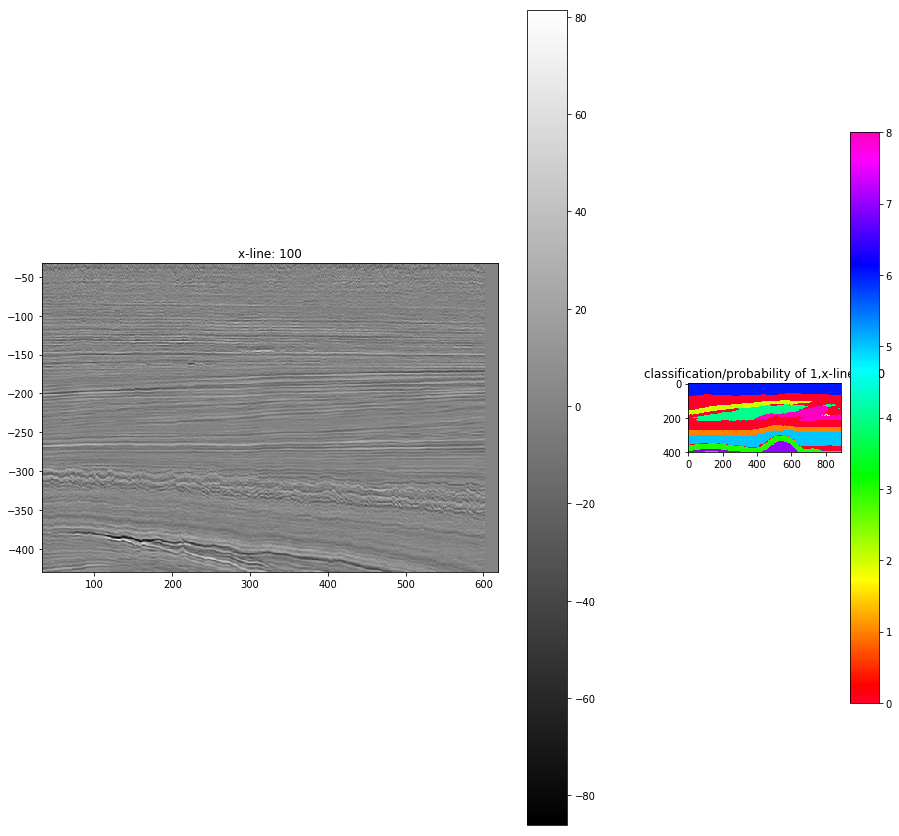

Total time elapsed during prediction: 19.0  min.,  8.863902854919433  sec.


In [129]:
#### ---- Run an instance of the master function ----

# Run the master function and save the output in the output dictionary output_dict
output_dict1 = master(
    segy_filename = filenames,     # Seismic filenames
    inp_format = inp_res,     # Format of input seismic
    cube_incr = cube_incr,     # Increments in each direction to create a training cube
    train_dict = train_dict,     # Input training dictionary
    pred_dict = pred_dict,     # Input prediction dictionary
    #mode = 'train'     # Input mode ('train', 'predict', or 'full' for both training AND prediction)
    mode = 'predict'     # Input mode ('train', 'predict', or 'full' for both training AND prediction)
)

(1, 887, 398, 1) 8.0 0.0


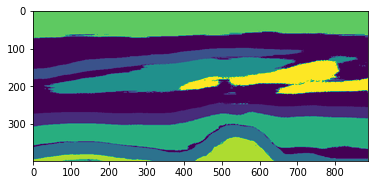

In [133]:
pred = output_dict1['pred']
print(pred.shape, np.max(pred), np.min(pred))
plt.imshow(pred[0, :,:,0].T,interpolation="spline16", vmin=0, vmax=8)

In [131]:
# Show additional details about the prediciton
"""
show_details(
    filenames[0],
    cube_incr,
    pred,
    inline = 400,
    inl_start = 356,
    xline = 400,
    xl_start = 400,
    slice_number = 200,
    slice_incr = 3,
    show_prob=False
)
"""


### Save/load functions
## returns a prediction cube
## identical to the one saved
#prediction = np.load('filename.npy')
#
## returns a compiled model
## identical to the one saved
#loaded_model = keras.models.load_model('filename.h5')

'\nshow_details(\n    filenames[0],\n    cube_incr,\n    pred,\n    inline = 400,\n    inl_start = 356,\n    xline = 400,\n    xl_start = 400,\n    slice_number = 200,\n    slice_incr = 3,\n    show_prob=False\n)\n'